Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np
import pandas as pd
import os
import random
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive/')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
!ls "/content/gdrive/MyDrive/datasets/cancer"

Test  Train


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/datasets/cancer/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/datasets/cancer/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [6]:
batch_size = 32
img_height = 180
img_width = 180

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [7]:
## Let us look at distribution of images. 
images_per_class = {}
image_paths_per_class = {}
for folder_name in ('actinic keratosis', 'basal cell carcinoma', 'dermatofibroma',  'melanoma',  'nevus',  'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'):
    folder_path = os.path.join(data_dir_train, folder_name)
    # picking a random image path per class
    image_paths_per_class[folder_name] = random.choice(os.listdir(folder_path))
    files_count = 0;
    for fname in os.listdir(folder_path):
          files_count +=1
    images_per_class[folder_name] = files_count

<BarContainer object of 9 artists>

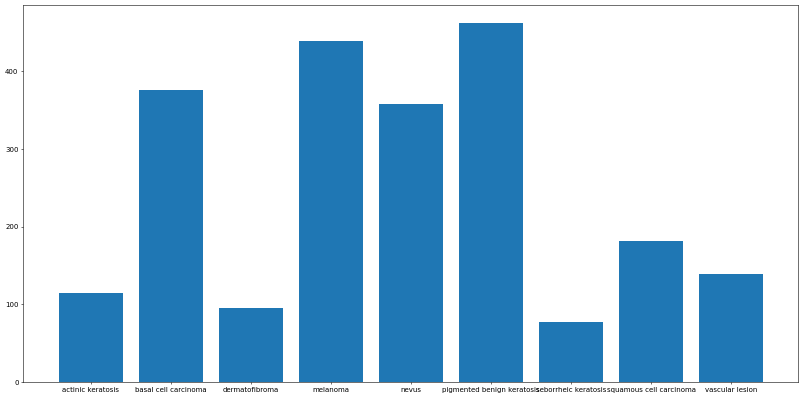

In [8]:
keys = images_per_class.keys()
values = images_per_class.values()
figure(figsize=(20, 10), dpi=50)
plt.bar(keys, values)

In [9]:
images_per_class

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

Notice the class imbalance, Pigmented Benign, Melanoma and Basal Cell Carcinoma have highest number of images while actinic keratosis, dermatofibroma and seborrheic keratosis have the lowest counts. This is going to impact the training hence we need to treat the imbalance. 

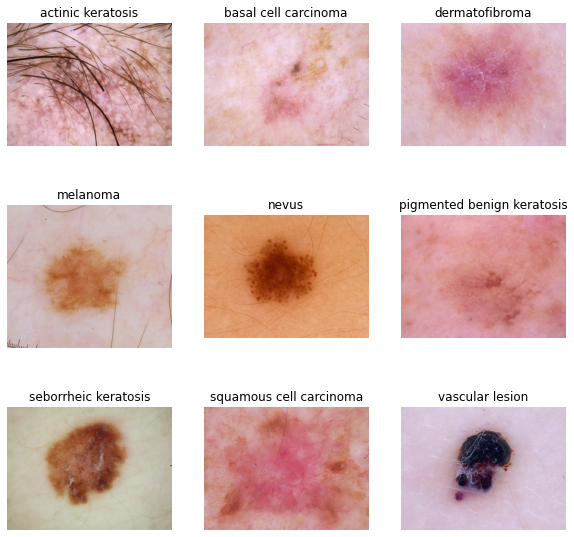

In [10]:
# example of loading an image with the Keras API
import matplotlib.image as mpimg

# Create a code to visualize one instance of all the nine classes present in the dataset
plt.figure(figsize=(10, 10))
i = 0;
for key in image_paths_per_class:
  ax = plt.subplot(3, 3, i + 1)
  i += 1
  image_mp = mpimg.imread(os.path.join(data_dir_train, key, image_paths_per_class[key]))
  imgplot=plt.imshow(image_mp)
  plt.title(key) #image_paths_per_class[key]
  plt.axis("off")
  plt.plot()
        

Use 80% of the images for training, and 20% for validation.

### Create a dataset

Define some parameters for the loader:

In [11]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [12]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', image_size=(180,
    180), shuffle=True, seed=123
)

Found 118 files belonging to 9 classes.


In [14]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create simple model



#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
## Declaring some functions
from keras.optimizers import SGD

def compile_and_fit(model, epochs=20):
  
  model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  model.summary()
  history = model.fit(train_ds,validation_data=val_ds,epochs=epochs,shuffle=True)

  return history


def visualize_results(epochs=20):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy'] 

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [17]:
### Your code goes here

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

num_classes = len(class_names)
img_rows, img_cols = 180, 180
input_shape = (img_rows, img_cols, 3)

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape)

model = tf.keras.Sequential([
  normalization_layer,
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),  
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(128, 3, padding='same', activation='relu'),  
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### Compile and fit the model
Choose an appropirate optimiser and loss function for model training 

In [18]:
history = compile_and_fit(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 128)       0

### Visualizing training results

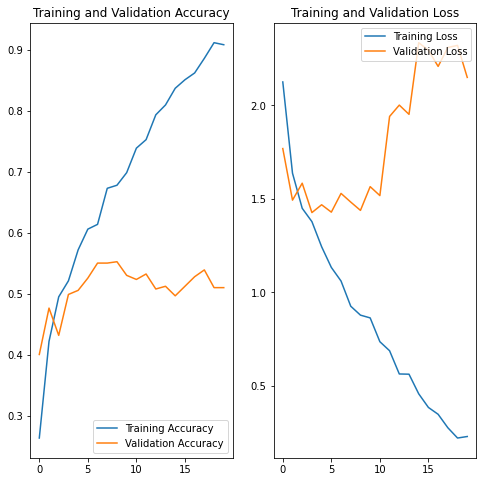

In [19]:
visualize_results()

### Findings
There is significant gap between training accuracy and validation accuracy. The training loss has come down drastically while the validation loss increased. The model has overfit the training the data.

### Next Steps
- Apply data augmentation 
- Apply regularization. 

## Apply Data Augmentation

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=input_shape),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

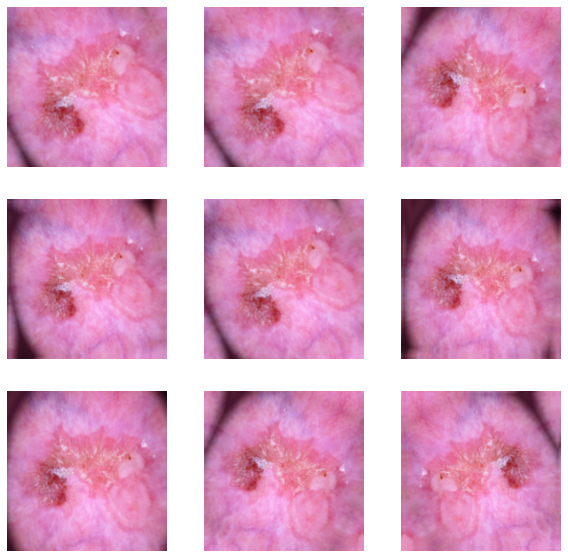

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model

In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=input_shape), 
  layers.experimental.preprocessing.RandomRotation(0.1), 
  layers.experimental.preprocessing.RandomZoom(0.1), 
  normalization_layer,

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.25), 
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.25), 
  
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.2), 

  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.2), 
  layers.Dense(num_classes, activation='softmax')
])

### Compiling and Fit with Data Augmentation and Drop outs

In [23]:
history = compile_and_fit(model)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_1 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 32)       

In [24]:
# Since we observed some underfitting let us increase the layers and reducing drop outs

model = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=input_shape),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1), 
  normalization_layer,

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.1), 

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.1), 
  
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.25), 
  layers.Dense(num_classes, activation='softmax')
])

In [25]:
history = compile_and_fit(model)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_2 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom_2 (RandomZoom)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)       

### Visualizing the results

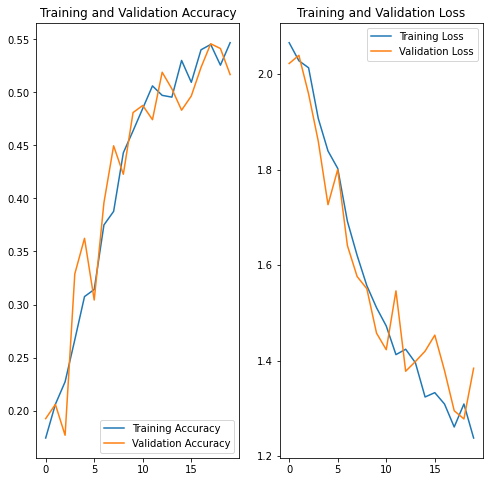

In [26]:
visualize_results()


### Findings

Adding more layers is not helping the model learn more, I see Less overfitting but the model's accuracy is still low. 


## Applying Batch Normalization

In [27]:
model = tf.keras.Sequential([
                             
  layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=input_shape), 
  layers.experimental.preprocessing.RandomRotation(0.1), 
  layers.experimental.preprocessing.RandomZoom(0.1), 
  normalization_layer,

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### Compile and Fit with Batch Normalization

In [28]:
history = compile_and_fit(model)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_3 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_3 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom_3 (RandomZoom)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 32)       

### Visualizing the results

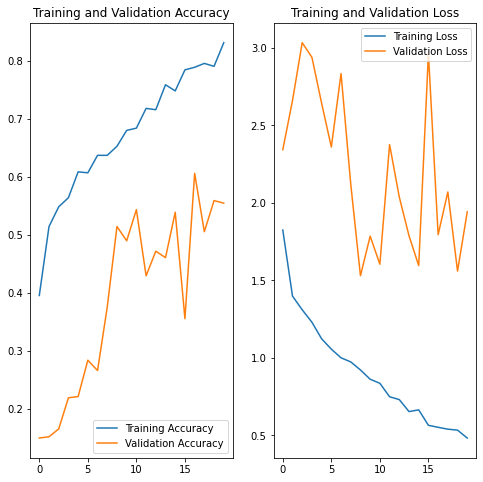

In [29]:
visualize_results()

### Findings

The accuracy has improved but there is some overfitting observed.

### Next steps
Re-introduce some regularization (dropouts, l2) with additional layers.

### Applying Batch Normalization with Dropouts

In [30]:

model = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=input_shape), 
  layers.experimental.preprocessing.RandomRotation(0.1), 
  layers.experimental.preprocessing.RandomZoom(0.1), 

  normalization_layer,

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.2),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.2),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.2),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.2),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.2),
  
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.2),
  
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.8),
  layers.Dense(num_classes, activation='softmax')
])

In [31]:
# Increasing the epochs since adding dropouts resulted in underfitting earlier.
history = compile_and_fit(model)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_4 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_4 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom_4 (RandomZoom)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 90, 90, 32)       

### Visualizing the results

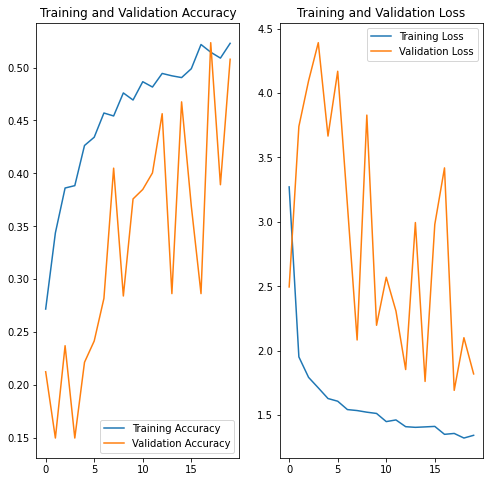

In [32]:
visualize_results()

### Findings

Dropouts negatively impacting the model causing underfitting, though the gap between train accuracy and validation accuracy is minimum.

## Find the distribution of classes in the training dataset.
### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

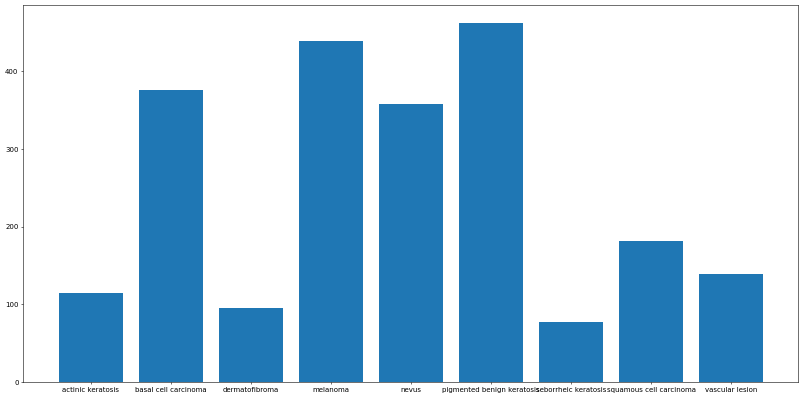

In [33]:
## Your code goes here.

keys = images_per_class.keys()
values = images_per_class.values()
figure(figsize=(20, 10), dpi=50)
plt.bar(keys, values)

#### Findings on Distribution of data: 
#### - Which class has the least number of samples?
Actinic keratosis, dermatofibroma and seborrheic keratosis have the lowest number of samples. 

#### - Which classes dominate the data in terms proportionate number of samples?
Pigmented Benign, Melanoma and Basal Cell Carcinoma have highest number of images

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [34]:
!pip install Augmentor

In [35]:
# Let us clean up any existing output directories if the augmentor was already run
import shutil
path_to_training_dataset = "/content/gdrive/MyDrive/datasets/cancer/Train/"
for folder_name in class_names:
    folder_path = os.path.join(data_dir_train, folder_name+'/output')
    if os.path.isdir(folder_path):
      shutil.rmtree(folder_path)

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [36]:
path_to_training_dataset = "/content/gdrive/MyDrive/datasets/cancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8232789510>: 100%|██████████| 500/500 [00:18<00:00, 27.08 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/cancer/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F82800E0050>: 100%|██████████| 500/500 [00:18<00:00, 26.36 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F82800EFB10>: 100%|██████████| 500/500 [00:19<00:00, 25.75 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F823DFC64D0>: 100%|██████████| 500/500 [01:25<00:00,  5.86 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=796x682 at 0x7F824408D750>: 100%|██████████| 500/500 [01:26<00:00,  5.81 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/cancer/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F82905497D0>: 100%|██████████| 500/500 [00:19<00:00, 26.16 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F82800E6890>: 100%|██████████| 500/500 [00:41<00:00, 12.14 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F823CD994D0>: 100%|██████████| 500/500 [00:18<00:00, 26.51 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8232718F10>: 100%|██████████| 500/500 [00:19<00:00, 25.60 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
# create a data frame with samples under each class. 
pd.DataFrame(images_per_class.items()).head(10)

# The original training dataset had 2239 files. 

,0,1
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


In [39]:
import glob as glob
dataframe_dict_original = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_original =  [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(dataframe_dict_original, lesion_list_original))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [40]:

path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2['Label'].value_counts()

squamous cell carcinoma       500
pigmented benign keratosis    500
melanoma                      500
actinic keratosis             500
seborrheic keratosis          500
dermatofibroma                500
vascular lesion               500
nevus                         500
basal cell carcinoma          500
Name: Label, dtype: int64

This shows we added 4500 images, 500 per each class for 9 classes.

In [41]:
# Combining both the folders
new_df = original_df.append(df2)

In [42]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [44]:
data_dir_train="/content/gdrive/MyDrive/datasets/cancer/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####  Create your model (make sure to include normalization)

In [46]:
## your code goes here

from tensorflow.keras.regularizers import l2
model = tf.keras.Sequential([
 layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=input_shape), 
  layers.experimental.preprocessing.RandomRotation(0.1), 
  layers.experimental.preprocessing.RandomZoom(0.1), 
  normalization_layer,

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation='softmax')

])

#### Compile and fit

In [47]:
history = compile_and_fit(model, 30)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_5 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_5 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom_5 (RandomZoom)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 90, 90, 32)       

#### Visualize the model results

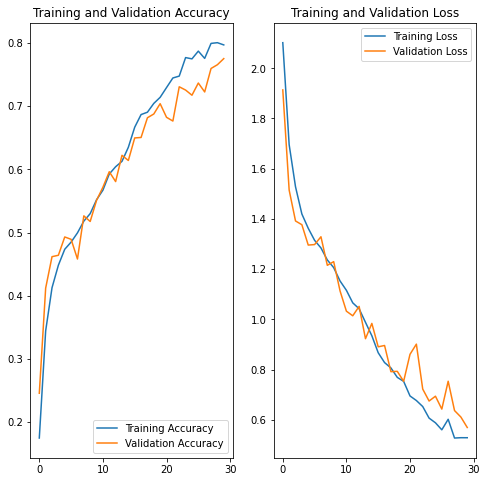

In [48]:
visualize_results(30)

### Findings

There is very minimal gap between the training accuracy and validation accuracy hence we successfully treated the overfitting and also increased the accuracy after augmenting each class with 500 samples. The loss as well reduced similarly for training and validation data sets

### Next Steps

See if accuracy increases with more epochs

### Train the more feature maps and increased epochs

In [49]:
## your code goes here

model = tf.keras.Sequential([
 layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=input_shape), 
  layers.experimental.preprocessing.RandomRotation(0.1), 
  layers.experimental.preprocessing.RandomZoom(0.1), 
  normalization_layer,

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  
  layers.Flatten(),
  layers.Dense(num_classes, activation='softmax')

])

### Compile and fit

In [50]:
history=compile_and_fit(model,50)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_6 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_6 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom_6 (RandomZoom)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 180, 180, 64)      1792      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 90, 90, 64)       

### Visualize the model results

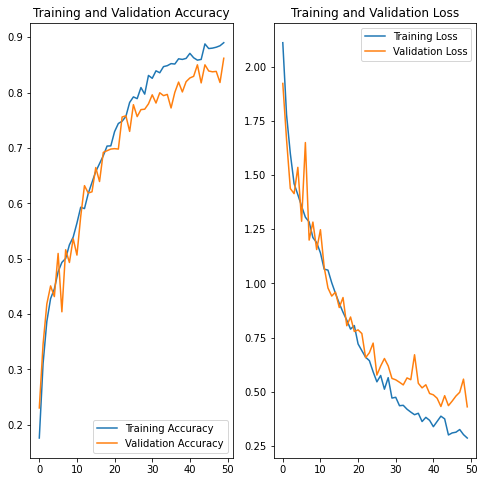

In [51]:
visualize_results(epochs=50)

### Findings

Good improvement on both training and validation accuracy from the previous model, we can consider this as the best model so far. There is on caveat with this model, the training time has increased by 3 fold from 10 min to 30 min which can be sorted by throwing more GPUs if cost is not a concern.

# Summary. 

Did you get rid of underfitting/overfitting? Did class rebalance help?

The following table summarizes the entire process. In summary we were able to address the overfitting by introducing dropouts that created an issue of underitting which was later resolved with increase the data using augmentation. The final layer did not show any overfitting hence no regularization was needed. 

** During training I observed the accuracy numbers fluctuate a lot (could be due to dropouts) but very minimal (+/-3), consider the below numbers as indicative only, these cannot be compared with the actual results above.

 |Model Name	|Train, Validation Accuracy	|Iterations	|	Observations	| Next Steps|
 |--|--|--|--|--|
|Simple Model	|~94, ~78	|20	| There is significant gap between training accuracy and validation accuracy. The training loss has come down drastically while the validation loss increased. The model has overfit the training the data.| Apply regularization and data augmentation to increase robustness.|
Model with Data Augmentation, Drop out regularization|	62, 65 |	20|	Less overfitting, but the model has learnt less from the data as a result the accuracy dropped resulting in underfitting | Add more layers|
Model with more layers without dropouts|	59, 64|	20	|	Adding more layers is not helping the model learn more, I see Less overfitting but the model's accuracy is still low. |Apply batch normalization without dropouts
Model with batch normalization without dropouts|89.6, 69.5|20| The accuracy has improved but there is some overfitting observed. | Re-introduce some regularization (dropouts, l2) with additional layers.
| Model with batch normalization and dropouts|	52, 50|	20	|	Dropouts negatively impacting the model causing underfitting, though the gap between train accuracy and validation accuracy is minimum. | Use Augmentation to increase the volume of training data. 
Model with augmentation |	80.6, 79 | 30 | There is very minimal gap between the training accuracy and validation accuracy hence we successfully treated the overfitting and also increased the accuracy after augmenting each class with 500 samples. The loss as well reduced similarly for training and validation data sets | See if accuracy increases with more epochs
Model with augmentation with more feature maps and increased epochs | 88,86 | 50 | Good improvement on both training and validation accuracy from the previous model, we can consider this as the best model so far. There is on caveat with this model, the training time has increased by 3 fold from 10 min to 30 min which can be sorted by throwing more GPUs if cost is not a concern.




In [53]:
## Evaluating Test Accuracy for chosen Model. 
model.evaluate(test_ds)

4/4 [==============================] - 4s 23ms/step - loss: 5.0137 - accuracy: 0.4068


[5.013737201690674, 0.4067796468734741]